In [9]:
from utils.modelUtils import load_medsam
from classes.MedSAMClass import MedSAMWrapper, MedSAMInferer

import utils.promptUtils as prUt
import utils.analysisUtils as anUt
from utils.imageUtils import read_im_gt

# Obtain model, image, gt
device = 'cuda'
medsam_checkpoint_path = '/home/t722s/Desktop/UniversalModels/TrainedModels/medsam_vit_b.pth'

medsam_model = load_medsam(medsam_checkpoint_path)
medsam_wrapper = MedSAMWrapper(medsam_model, device)
medsam_inferer = MedSAMInferer(medsam_wrapper, device)

# img_path = '/home/t722s/Desktop/Datasets/BratsMini/imagesTs/BraTS2021_01646.nii.gz'
# gt_path = '/home/t722s/Desktop/Datasets/BratsMini/labelsTs/BraTS2021_01646.nii.gz'
# img, gt = read_im_gt(img_path, gt_path)

# img_path = '/home/t722s/Desktop/Datasets/amosForUniversegTest/imagesTs/amos_0001.nii.gz'
# gt_path = '/home/t722s/Desktop/Datasets/amosForUniversegTest/labelsTs/amos_0001.nii.gz'
# img, gt = read_im_gt(img_path, gt_path, 2)

img_path = '/home/t722s/Desktop/Datasets/Dataset350_AbdomenAtlasJHU_sub/imagesTr/BDMAP_00000001_0000.nii.gz'
gt_path = '/home/t722s/Desktop/Datasets/Dataset350_AbdomenAtlasJHU_sub/labelsTr/BDMAP_00000001.nii.gz'
img, gt = read_im_gt(img_path, gt_path, 9)

In [10]:
# Experiment: 2d bounding box per slice with foreground
box_prompt = prUt.get_minimal_boxes_row_major(gt, 3, 3)

segmentation = medsam_inferer.predict(img, box_prompt)
anUt.compute_dice(segmentation, gt)

Performing inference on slices: 100%|██████████| 52/52 [00:08<00:00,  6.24it/s]


0.837091419292181

In [ ]:
# Experiment: 3d bounding box is sliced to give 2d bboxes
box_prompt = prUt.get_3d_box_for_2d(gt, 3, 3) # this function needs to be reworked for new row-major order

In [11]:
box_prompt

Boxes2d prompt({132: array([182, 233, 213, 254]), 133: array([174, 224, 220, 257]), 134: array([173, 222, 224, 259]), 135: array([169, 219, 228, 263]), 136: array([167, 217, 231, 263]), 137: array([165, 215, 233, 265]), 138: array([162, 213, 270, 265]), 139: array([162, 211, 275, 265]), 140: array([160, 211, 279, 267]), 141: array([160, 208, 283, 268]), 142: array([158, 200, 284, 268]), 143: array([156, 193, 284, 270]), 144: array([154, 179, 286, 270]), 145: array([145, 171, 288, 270]), 146: array([140, 169, 288, 270]), 147: array([134, 168, 292, 270]), 148: array([131, 164, 297, 268]), 149: array([127, 164, 299, 268]), 150: array([123, 162, 303, 267]), 151: array([121, 158, 304, 263]), 152: array([121, 158, 308, 263]), 153: array([120, 155, 310, 259]), 154: array([118, 151, 312, 259]), 155: array([114, 149, 310, 261]), 156: array([114, 142, 308, 261]), 157: array([114, 137, 301, 259]), 158: array([114, 137, 293, 254]), 159: array([114, 133, 288, 248]), 160: array([116, 131, 215, 226])

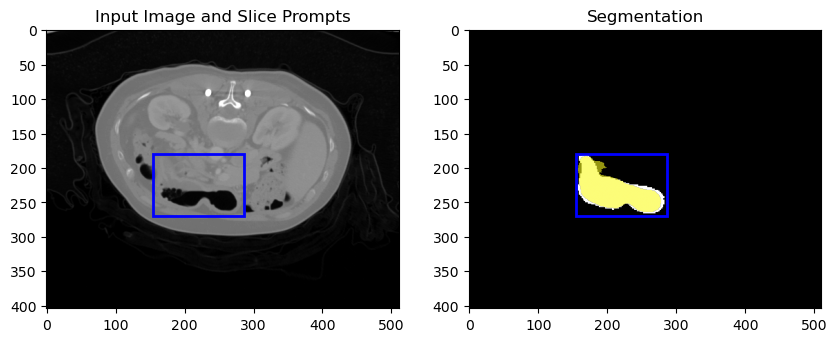

0.9089673913043478

In [24]:
slice_idx = 144
anUt.show_seg_row_major(slice_idx, img, gt, segmentation, box_prompt= box_prompt)